# SVM running with only VVR_1 and VVR_2

Import libraries. 

In [2]:
# Import necessary libraries
import json
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, confusion_matrix
import pandas as pd
import logging
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 
from collections import Counter

# Import data 

In [3]:
# Load the data into pandas dataframes
X_train_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_train_12.csv')
y_train_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_train_12.csv')
X_test_12 = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_test_12.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_test.csv')

X_train_12 = X_train_12.drop(columns='Unnamed: 0', axis=1)
y_train_12 = y_train_12.drop(columns='Unnamed: 0', axis=1)
X_test_12 = X_test_12.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

print(X_train_12.columns)
print(X_test_12.columns)

# Convert the DataFrame to a 1-dimensional NumPy array
y_train_12 = y_train_12.values.ravel()
y_test = y_test.values.ravel()


Index(['Sum_1', 'Sum_2'], dtype='object')
Index(['Sum_1', 'Sum_2'], dtype='object')


# Model with inner and outer split
https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html 

In [3]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC


# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Create the pipeline with RFE and the model
rfe = RFE(estimator=DecisionTreeClassifier())
model = SVC(probability=True)
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

param_grid = {
    'm__C': [0.1],  # Regularization parameter
    'm__kernel': ['poly'],  # Kernel type
    'm__gamma': ['auto'],  # Kernel coefficient
    'm__class_weight': [{0: 0.6428571428571429, 1: 2.25}],  # Class weights
    # 's__n_features_to_select': [10]  # Number of features to select with RFE
}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_12, y_train_12, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_12.shape)
print(y_train_12.shape)

# Fit model to training data to get best parameters
model.fit(X_train_12, y_train_12)

# Print best parameters
print(model.best_params_)

# Print the features that were selected with RFE

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test_12)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test_12)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")


# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
# print(metrics.auc(fpr, tpr))


The mean score using nested cross-validation is: 0.676 ± 0.044
(77, 2)
(77,)
{'m__C': 0.1, 'm__class_weight': {0: 0.6428571428571429, 1: 2.25}, 'm__gamma': 'auto', 'm__kernel': 'poly'}
(34,)
(34,)

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70        23
           1       0.43      0.55      0.48        11

    accuracy                           0.62        34
   macro avg       0.59      0.60      0.59        34
weighted avg       0.65      0.62      0.63        34

[[15  8]
 [ 5  6]]
AUC-PR: 0.648


# Optimized code

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.svm import SVC


def build_pipeline():
    """Builds the machine learning pipeline with RFE and RandomForestClassifier."""
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0))
    model = SVC(probability=True)
    return Pipeline(steps=[('feature_selection', rfe), ('classifier', model)])

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__class_weight': [{0: 0.75, 1: 1.48}, None],  # Class weights      
        # 'feature_selection__n_features_to_select': [5, 10, 20, 40, 80]  # Number of features to select with RFE
        'm__C': [0.1],  # Regularization parameter
        'm__kernel': ['poly'],  # Kernel type
        'm__gamma': ['auto'],  # Kernel coefficient
        
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()
    param_grid = get_param_grid()
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']
    train_scores = cv_results['train_score']
    
    print(f"Test scores for each fold: {test_scores}")
    print(f"Training scores for each fold: {train_scores}")
    print(f"The mean test score using nested cross-validation is: {test_scores.mean():.3f} ± {test_scores.std():.3f}")
    print(f"The mean training score using nested cross-validation is: {train_scores.mean():.3f} ± {train_scores.std():.3f}")
    
    return cv_results


def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_train, y_train, X_test, y_test):
    """Evaluates the model on the training set per fold and on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]
    
    # Evaluate on training set for each fold
    for idx, estimator in enumerate(best_estimator_per_fold):
        print(f"\nEvaluating fold {idx + 1} on training set")
        y_train_pred = estimator.predict(X_train)
        
        print("\nClassification Report on Training Set:")
        print(classification_report(y_train, y_train_pred))
        print(confusion_matrix(y_train, y_train_pred))
        
        y_train_proba = estimator.predict_proba(X_train)[:, 1]
        plot_curves(y_train, y_train_proba, y_train_pred)
        
        precision, recall, _ = precision_recall_curve(y_train, y_train_proba)
        auc_pr = auc(recall, precision)
        print(f"Training AUC-PR: {auc_pr:.3f}")

    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    plot_curves(y_test, y_test_proba, y_test_pred)
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")

# Assuming X_train_12, y_train_12, X_test_12, and y_test are predefined
random_seed = 42

cv_results = perform_nested_cv(X_train_12, y_train_12, random_state=random_seed)
evaluate_model(cv_results, X_train_12, y_train_12, X_test_12, y_test)


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/_utils.py", line 72, in __call__
    return self.func(**kwargs)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 598, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 129, in __call__
    return self.function(*args, **kwargs)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 883, in _fit_and_score
    estimator = estimator.set_params(**clone(parameters, safe=False))
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 239, in set_params
    self._set_params("steps", **kwargs)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/utils/metaestimators.py", line 71, in _set_params
    super().set_params(**params)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 291, in set_params
    valid_params[key].set_params(**sub_params)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 279, in set_params
    raise ValueError(
ValueError: Invalid parameter 'max_depth' for estimator SVC(class_weight={0: 0.75, 1: 1.48}, probability=True). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 970, in fit
    self._run_search(evaluate_candidates)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 1527, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 916, in evaluate_candidates
    out = parallel(
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 67, in __call__
    return super().__call__(iterable_with_config)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 2007, in __call__
    return output if self.return_generator else list(output)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 1650, in _get_outputs
    yield from self._retrieve()
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 1754, in _retrieve
    self._raise_error_fast()
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 1789, in _raise_error_fast
    error_job.get_result(self.timeout)
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 745, in get_result
    return self._return_or_raise()
  File "/Users/dionnespaltman/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 763, in _return_or_raise
    raise self._result
ValueError: Invalid parameter 'max_depth' for estimator SVC(class_weight={0: 0.75, 1: 1.48}, probability=True). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].


# Confusion matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_6433/1228220501.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


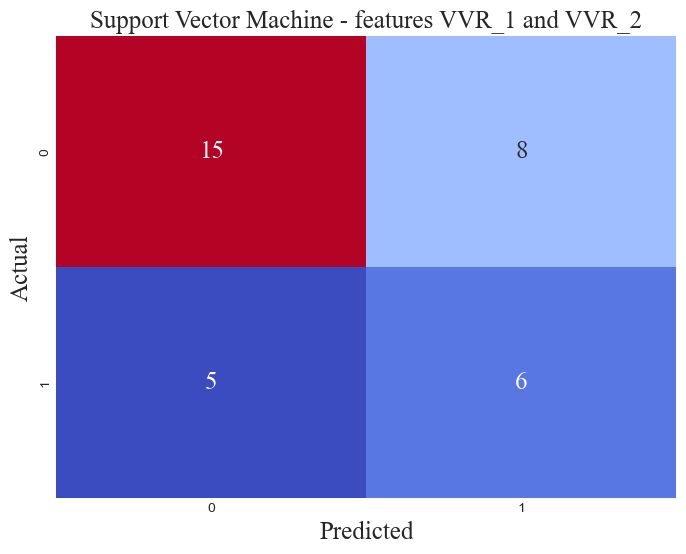

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("coolwarm", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Support Vector Machine - features VVR_1 and VVR_2', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()